<a href="https://colab.research.google.com/github/GECarlo/CodingDojo/blob/main/Intro_to_Boosting_Exercise_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Gradient Boosting

![gradient boosting image](https://media.geeksforgeeks.org/wp-content/uploads/20200721214745/gradientboosting.PNG)

Image thanks to [Geeks for Geeks](https://www.geeksforgeeks.org/ml-gradient-boosting/)

In this assignment you will:
1. import and prepare a dataset for modeling
2. test and evaluate 3 different boosting models and compare the fit times of each.
3. tune the hyperparameters of the best model to reduce overfitting and improve performance.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline

# ML model
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# metrics
from sklearn.metrics import classification_report, plot_confusion_matrix

In this assignment you will be working with census data.  Your goal is to predict whether a person will make more or less than $50k per year in income.

The data is available [here](https://drive.google.com/file/d/1drlRzq-lIY7rxQnvv_3fsxfIfLsjQ4A-/view?usp=sharing)

In [3]:
# load file
filename = '/content/drive/MyDrive/Colab Notebooks/census_income - census_income.csv'
df = pd.read_csv(filename)
df.head()

,Unnamed: 0,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
0,0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Prepare your dataset for modeling.

Remember to: 
1. Check for missing data, bad data, and duplicates.
2. Check your target class balance.
3. Perform your validation split
4. Create a preprocessing pipeline to use with your models.
5. Fit and evaluate your models using pipelines

In [4]:
# check dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      32561 non-null  int64 
 1   age             32561 non-null  int64 
 2   workclass       32561 non-null  object
 3   education       32561 non-null  object
 4   marital-status  32561 non-null  object
 5   occupation      32561 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  32561 non-null  object
 13  income-class    32561 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.5+ MB


In [5]:
df.shape

(32561, 14)

In [6]:
# check for missing, inconsistent, and duplicate data
df.isna().sum()

Unnamed: 0        0
age               0
workclass         0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income-class      0
dtype: int64

In [7]:
df.drop(df.filter(regex="Unname"),axis=1, inplace=True)
df.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [8]:
duplicates = df.duplicated()
df[duplicates]

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
352,33,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
391,27,Private,Bachelors,Never-married,Craft-repair,Not-in-family,White,Male,0,0,50,United-States,<=50K
563,24,Private,HS-grad,Never-married,Handlers-cleaners,Unmarried,Black,Female,0,0,40,United-States,<=50K
570,24,Private,HS-grad,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
673,33,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32503,47,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
32512,20,Private,HS-grad,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,40,United-States,<=50K
32527,22,Private,Some-college,Never-married,Adm-clerical,Own-child,White,Male,0,0,40,United-States,<=50K
32557,40,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K


In [9]:
df.drop_duplicates(keep = 'first')

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32554,53,Private,Masters,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
32555,22,Private,Some-college,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32556,27,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,58,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [10]:
df.describe()

,age,capital-gain,capital-loss,hours-per-week
count,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1077.648844,87.303830,40.437456
std,13.640433,7385.292085,402.960219,12.347429
min,17.000000,0.000000,0.000000,1.000000
25%,28.000000,0.000000,0.000000,40.000000
50%,37.000000,0.000000,0.000000,40.000000
75%,48.000000,0.000000,0.000000,45.000000
max,90.000000,99999.000000,4356.000000,99.000000


In [11]:
capital_gains = df['capital-gain'] > 99000

In [12]:
df[capital_gains].value_counts().sum()

# capital-gain > 99000 has 159 values. hence, we will keep this

159

In [13]:
df.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [14]:
df['workclass'].value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

In [15]:
df['workclass'] = df['workclass'].replace({'?': 'Private'})
df['workclass'].value_counts()

Private             24532
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

In [16]:
df['occupation'].value_counts()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

In [17]:
df['occupation'] = df['occupation'].replace({'?': 'Prof-specialty'})
df['occupation'].value_counts()

Prof-specialty       5983
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

In [18]:
df['native-country'].value_counts()

United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                      

In [19]:
df['native-country'] = df['native-country'].replace({'?': 'United-States'})
df['native-country'].value_counts()

United-States                 29753
Mexico                          643
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                           29
Greece                      

# Data Preparation

using OneHotEncoding

In [20]:
# determine target y and features X
y = df['income-class']
X = df.drop(columns = 'income-class')

In [22]:
# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [23]:
# instantiate column selector
cat_selector = make_column_selector(dtype_include = 'object')
num_selector = make_column_selector(dtype_include = 'number')

In [25]:
# instantiate encoder
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
scaler = StandardScaler()

In [26]:
# create pipeline
cat_pipe = make_pipeline(ohe, scaler)
num_pipe = make_pipeline(scaler)

In [27]:
# set tuples
cat_tuple = (cat_pipe, cat_selector)
num_tuple = (num_pipe, num_selector)

In [28]:
# instantiate column transformer
preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder = 'passthrough')

In [29]:
# fit the data
preprocessor.fit(X_train, y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f9b0810c590>),
                                ('pipeline-2',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f9b0810c5d0>)])

In [30]:
# transform processed data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# eXtreme Gradient Boosting
We are going to compare both metrics and fit times for our models.  Notice the 'cell magic' in the top of the cell below.  By putting `%%time` at the top of a notebook cell, we can tell it to output how long that cell took to run.  We can use this to compare the speed of each of our different models.  Fit times can be very important for models in deployment, especially with very large dataset and/or many features.

Instantiate an eXtreme Gradient Boosting Classifier (XGBClassifier) below, fit it, and print out a classification report.  Take note of the accuracy, recall, precision, and f1-score, as well as the run time of the cell to compare to our next models.

In [37]:
%%time
# instantiate model
xgb = XGBClassifier()

# fit the model for target y
xgb.fit(X_train_processed, y_train)

# evaluate the model
train_score = xgb.score(X_train_processed, y_train)
test_score = xgb.score(X_test_processed, y_test)

# print scores
print(f'xgb training accuracy: {train_score}')
print(f'xgb testing accuracy: {test_score}')

xgb training accuracy: 0.8631859131859132
xgb testing accuracy: 0.8651271342586906
CPU times: user 4.21 s, sys: 18.6 ms, total: 4.22 s
Wall time: 4.23 s


Which target class is your model better at predicting?  Is it significantly overfit?

# More Gradient Boosting

Now fit and evaluate a Light Gradient Boosting Machine and a the Scikit Learn (sklearn) gradient boost model.  Remember to use the `%%time` cell magic command to get the run time.

## LightGBM

In [40]:
%%time
# instantiate model
lgb = LGBMClassifier()

# fit the model for target y
lgb.fit(X_train_processed, y_train)

# evaluate the model
train_score = lgb.score(X_train_processed, y_train)
test_score = lgb.score(X_test_processed, y_test)

# print scores
print(f'lgb training accuracy: {train_score}')
print(f'lgb testing accuracy: {test_score}')

lgb training accuracy: 0.884889434889435
lgb testing accuracy: 0.8760594521557549
CPU times: user 1.83 s, sys: 15.6 ms, total: 1.85 s
Wall time: 1.84 s


## GradientBoostingClassifier

In [39]:
%%time
# instantiate model
gbm = GradientBoostingClassifier()

# fit the model for target y
gbm.fit(X_train_processed, y_train)

# evaluate the model
train_score = gbm.score(X_train_processed, y_train)
test_score = gbm.score(X_test_processed, y_test)

# print scores
print(f'gbm training accuracy: {train_score}')
print(f'gbm testing accuracy: {test_score}')

gbm training accuracy: 0.8647010647010647
gbm testing accuracy: 0.8673381648446137
CPU times: user 5.03 s, sys: 9.91 ms, total: 5.04 s
Wall time: 5.04 s


Observation:

lgbm provided the best train/test results (88.4/87.6) with a total time of 1.97s

while gbm was slightly better than xgbm by 0.01 it was slower by 42 secs. Hence, we will use xgbm as it is faster and the gains are negligible.


# Tuning Gradient Boosting Models

Tree-based gradient boosting models have a LOT of hyperparameters to tune.  Here are the documentation pages for each of the 3 models you used today:

1. [XGBoost Hyperparameter Documentation](https://xgboost.readthedocs.io/en/latest/parameter.html)
2. [LightGBM Hyperparameter Documentation](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)
3. [Scikit-learn Gradient Boosting Classifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Choose the model you felt performed the best when comparing multiple metrics and the runtime for fitting, and use GridSearchCV to try at least 2 different values each for 3 different hyper parameters in boosting model you chose.

See if you can create a model with an accuracy between 86 and 90.


In [49]:
%%time
# instantiate model
xgb = XGBClassifier(max_leaves = 200, max_depth = 30)

# fit the model for target y
xgb.fit(X_train_processed, y_train)

# evaluate the model
train_score = xgb.score(X_train_processed, y_train)
test_score = xgb.score(X_test_processed, y_test)

# print scores
print(f'xgb training accuracy: {train_score}')
print(f'xgb testing accuracy: {test_score}')

# default score
# xgb training accuracy: 0.8631859131859132
# xgb testing accuracy: 0.8651271342586906

xgb training accuracy: 0.9593366093366094
xgb testing accuracy: 0.8643901240633829
CPU times: user 41.5 s, sys: 46.8 ms, total: 41.6 s
Wall time: 41.5 s


In [76]:
%%time
# instantiate model
lgb = LGBMClassifier(num_leaves = 100)

# fit the model for target y
lgb.fit(X_train_processed, y_train)

# evaluate the model
train_score = lgb.score(X_train_processed, y_train)
test_score = lgb.score(X_test_processed, y_test)

# print scores
print(f'lgb training accuracy: {train_score}')
print(f'lgb testing accuracy: {test_score}')

# default score
# lgb training accuracy: 0.884889434889435
# lgb testing accuracy: 0.8760594521557549

lgb training accuracy: 0.9062653562653563
lgb testing accuracy: 0.8736027515047291
CPU times: user 2.38 s, sys: 22.9 ms, total: 2.41 s
Wall time: 2.43 s


# Evaluation

Evaluate your model using a classifiation report and/or a confusion matrix.  Explain in text how your model performed in terms of precision, recall, and it's ability to predict each of the two classes.  Also talk about the benefits or drawbacks of the computation time of that model.

In [77]:
# define a function that takes true and predicted values as arguments
# and prints all 4 metrics

def evaluate_classification(y_true, y_predicted, average=None):
  accuracy = accuracy_score(y_true, y_predicted)
  recall = recall_score(y_true, y_predicted, average=average)
  precision = precision_score(y_true, y_predicted, average=average)
  f1 = f1_score(y_true, y_predicted, average=average)

  print(f'Accuracy: {accuracy} \nRecall: {recall} \nPrecision: {precision} \nF1 Score: {f1}')

In [79]:
train_pred = xgb.predict(X_train_processed)
test_pred = xgb.predict(X_test_processed)

print('xgb training scores')
print(classification_report(y_train, train_pred))

print('xgb testing scores')
print(classification_report(y_test, test_pred));

xgb training scores
              precision    recall  f1-score   support

       <=50K       0.96      0.98      0.97     18506
        >50K       0.94      0.89      0.91      5914

    accuracy                           0.96     24420
   macro avg       0.95      0.93      0.94     24420
weighted avg       0.96      0.96      0.96     24420

xgb testing scores
              precision    recall  f1-score   support

       <=50K       0.90      0.93      0.91      6214
        >50K       0.74      0.65      0.69      1927

    accuracy                           0.86      8141
   macro avg       0.82      0.79      0.80      8141
weighted avg       0.86      0.86      0.86      8141



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


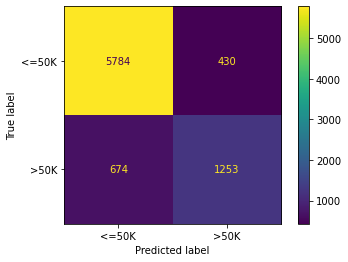

In [85]:
# create confusion matrics
plot_confusion_matrix(xgb, X_test_processed, y_test)  
plt.show();

In [86]:
train_pred = lgb.predict(X_train_processed)
test_pred = lgb.predict(X_test_processed)

print('lgb training scores')
print(classification_report(y_train, train_pred))

print('lgb testing scores')
print(classification_report(y_test, test_pred));

lgb training scores
              precision    recall  f1-score   support

       <=50K       0.92      0.96      0.94     18506
        >50K       0.85      0.75      0.79      5914

    accuracy                           0.91     24420
   macro avg       0.88      0.85      0.87     24420
weighted avg       0.90      0.91      0.90     24420

lgb testing scores
              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92      6214
        >50K       0.77      0.67      0.71      1927

    accuracy                           0.87      8141
   macro avg       0.83      0.80      0.82      8141
weighted avg       0.87      0.87      0.87      8141



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


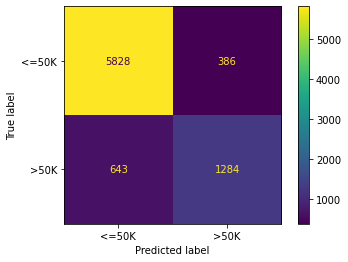

In [88]:
# create confusion matrics
plot_confusion_matrix(lgb, X_test_processed, y_test)  
plt.show();

# Conclusion

In this assignment you practiced:
1. data cleaning
2. instantiating, fitting, and evaluating boosting models using multiple metrics
3. timing how long it takes a model to fit and comparing run times between multiple models
4. and choosing a final model based on multiple metrics.

